In [1]:
import gymnasium as gym
import numpy as np

env = gym.make("BipedalWalker-v3", hardcore=False, render_mode="rgb_array")

frames = []
observation, info = env.reset()

# Reset the environment to generate the first observation
for _ in range(1000):
    # this is where you would insert your policy
    action = env.action_space.sample()

    # step (transition) through the environment with the action
    # receiving the next observation, reward and if the episode has terminated or truncated
    observation, reward, terminated, truncated, info = env.step(np.random.randint(size=(4,), low=-1, high = 1))
    frame = env.render()
    frames.append(frame)

    # If the episode has ended then we can reset to start a new episode
    if terminated or truncated:
        observation, info = env.reset()
        break

env.close()
print(observation.shape)

(24,)


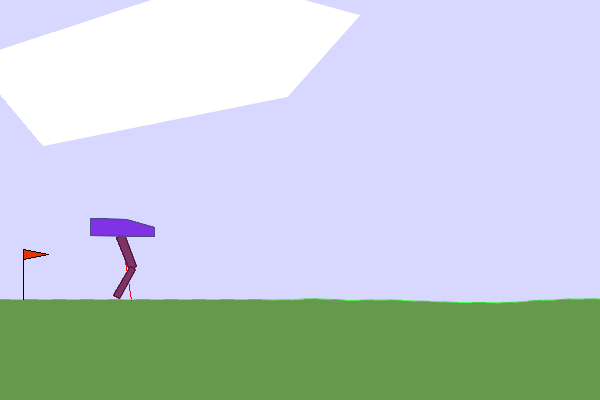

In [2]:
from PIL import Image
from IPython.display import display, Image as IPImage
import io

frames_pil = [Image.fromarray(frame.astype("uint8")) for frame in frames]

buf = io.BytesIO()
frames_pil[0].save(buf, format='GIF', save_all=True, append_images=frames_pil[1:], duration=50, loop=0)
buf.seek(0)

display(IPImage(data=buf.getvalue()))


In [18]:
import einx
import torch.nn as nn
import torch
import random

class DiscreteWalkerActionValueNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(24, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 3 ** 4)
        )
    def forward(self, observationTensor):
        flattenedQuality = self.network(observationTensor)
        # 4 joints, 3 actions per joint, categorical where action[0] corresponds to a speed of -1, action [4] corresponds to a speed of 0, action[8] speed of 1 for that joint
        #reshapedQuality = einx.rearrange("... (j1 j2 j3 j4) -> ... j1 j2 j3 j4", flattenedQuality, j1 = 3, j2 = 3, j3 = 3, j4 = 3)
        return flattenedQuality

    def sampleAction(self, flattenedQuality, epsilon=0):
        if random.random() < epsilon:
            idxArg = random.randint(0, 80)
        else:
            idxArg = flattenedQuality.argmax().detach().cpu().item()
        actionTakenIdx = idxArg
        joint1Idx = idxArg // 3 ** 3
        idxArg -= 3 ** 3 * joint1Idx
        joint2Idx = idxArg // 3 ** 2
        idxArg -= 3 ** 2 * joint2Idx
        joint3Idx = idxArg // 3 ** 1
        idxArg -= 3 ** 1 * joint1Idx
        joint4Idx = idxArg % 3
        action = np.array([joint1Idx, joint2Idx, joint3Idx, joint4Idx]) - 1
        return actionTakenIdx, action

agentNetwork = DiscreteWalkerActionValueNetwork()
actionQuality = agentNetwork(torch.tensor(observation))
actionQuality

tensor([-0.0207, -0.0668,  0.0822, -0.0635,  0.0049, -0.0060, -0.1326,  0.1058,
         0.0378, -0.0714, -0.0107, -0.0582, -0.0211, -0.0636,  0.0709, -0.0630,
         0.1013, -0.0078,  0.0620,  0.1003, -0.0608,  0.0877,  0.0487,  0.0469,
        -0.1290, -0.0456, -0.0920,  0.0571,  0.0724, -0.0810,  0.0533,  0.0110,
         0.0718,  0.0777,  0.0602, -0.0524, -0.0819,  0.0219,  0.0042,  0.0428,
         0.0868,  0.0229,  0.0162, -0.0857, -0.0061,  0.0060,  0.0413, -0.0432,
        -0.0587,  0.0888,  0.0782, -0.0629, -0.0542,  0.0816, -0.0445,  0.0078,
        -0.0640, -0.0668, -0.0212,  0.0426,  0.0296, -0.0963, -0.0006,  0.0751,
         0.0548,  0.0135, -0.0363, -0.0231, -0.0749,  0.0333,  0.0813, -0.0936,
         0.0471, -0.0647, -0.0482,  0.0768, -0.0234, -0.0233, -0.0281, -0.0753,
         0.0850], grad_fn=<ViewBackward0>)

In [20]:
# Key Idea: Q(s_t, a_t) = r_{t+1} + gamma * max_a Q(s_{t+1}, a)
# Need to record current state, reward gathered, and state entered as tuples to pass into network
class DDQNAgent(nn.Module):
    def __init__(self):
        super().__init__()
        self.qNetwork = DiscreteWalkerActionValueNetwork()
        self.targetNetwork = DiscreteWalkerActionValueNetwork()
        self.targetNetwork.eval()
        self.copyParamsToTarget()

    def copyParamsToTarget(self):
        self.targetNetwork.load_state_dict(self.qNetwork.state_dict())
        for param in self.targetNetwork.parameters():
            param.requires_grad = False

    def computeLoss(self, curStateTensor, actionTakenTensor, nextRewardTensor, nextStateTensor, termOrTruncTensor, gamma=0.99):
        self.targetNetwork.eval()
        # Choose best actions in next state according to online network:
        nextActionQualities = self.qNetwork(nextStateTensor)
        bestActionIndices = nextActionQualities.argmax(dim=-1)

        # Evaluate the quality of these actions according to the target network
        targetNetworkNextActionQualities = self.targetNetwork(nextStateTensor)
        chosenNextActionQualities = targetNetworkNextActionQualities[range(nextStateTensor.shape[0]), bestActionIndices]
        
        onlineTarget = nextRewardTensor + gamma * chosenNextActionQualities * termOrTruncTensor
        onlinePrediction = self.qNetwork(curStateTensor)[range(curStateTensor.shape[0]), actionTakenTensor]
        return ((onlineTarget - onlinePrediction) ** 2).mean()

    def computeLossFromReplayBufferSample(self, replayBufferSample, device = 'cpu'):
        realCurObservationBatch, realActionIndicesTaken, realRewardBatch, realNextObservationBatch, termOrTruncTensor = list(zip(*replayBufferSample))
        realCurObservationBatch = torch.tensor(np.stack(realCurObservationBatch))
        realActionIndicesTaken = torch.tensor(realActionIndicesTaken)
        realRewardBatch = torch.tensor(realRewardBatch)
        realNextObservationBatch = torch.tensor(np.stack(realNextObservationBatch))
        termOrTruncTensor = torch.tensor(termOrTruncTensor)
        return agent.computeLoss(realCurObservationBatch.to(device), realActionIndicesTaken.to(device), realRewardBatch.to(device), realNextObservationBatch.to(device), termOrTruncTensor.to(device))


agent = DDQNAgent()
fakeCurrentObservationBatch = torch.rand(size=(2, 24))
fakeActionsTaken = torch.randint(size = (2,), low = 0, high = 81)
fakeRewardBatch = torch.rand(size = (2, ))
fakeNextObservationBatch = torch.rand(size = (2, 24))
termOrTruncTensor = torch.ones(size = (2, ))
agent.computeLoss(fakeCurrentObservationBatch, fakeActionsTaken, fakeRewardBatch, fakeNextObservationBatch, termOrTruncTensor)

tensor(0.4922, grad_fn=<MeanBackward0>)

In [21]:
env = gym.make("BipedalWalker-v3", hardcore=False, render_mode="rgb_array")

def recordAgentInEnv(env, agent, epsilon=0, device='cpu'):
    replayBufferInEnv = []
    
    frames = []
    observation, info = env.reset()
    
    # Reset the environment to generate the first observation
    episodeReturn = 0
    while True:
        curObservation = observation
        with torch.no_grad():
            nextActionQualities = agent.qNetwork(torch.tensor(observation).to(device))
        actionIdxTaken, actionVec = agent.qNetwork.sampleAction(nextActionQualities, epsilon=epsilon)
        
        observation, reward, terminated, truncated, info = env.step(actionVec)

        replayBufferInEnv.append((curObservation, actionIdxTaken, reward, observation, int(not (terminated or truncated))))
        frame = env.render()
        frames.append(frame)
        episodeReturn += reward
    
        # If the episode has ended then we can reset to start a new episode
        if terminated or truncated:
            observation, info = env.reset()
            break
    return replayBufferInEnv, frames, episodeReturn

replayBuffer, _, _ = recordAgentInEnv(env, agent)

In [22]:
realCurObservationBatch, realActionIndicesTaken, realRewardBatch, realNextObservationBatch, termOrTruncBatch = list(zip(*replayBuffer))
realCurObservationBatch = torch.tensor(np.stack(realCurObservationBatch))
realActionIndicesTaken = torch.tensor(realActionIndicesTaken)
realRewardBatch = torch.tensor(realRewardBatch)
realNextObservationBatch = torch.tensor(np.stack(realNextObservationBatch))
termOrTruncTensor = torch.tensor(termOrTruncBatch)
agent.computeLoss(realCurObservationBatch, realActionIndicesTaken, realRewardBatch, realNextObservationBatch, termOrTruncTensor)


tensor(0.0038, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [23]:
agent.computeLossFromReplayBufferSample(replayBuffer)

tensor(0.0038, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [ ]:
from torch.optim import Adam
from tqdm import tqdm
import random
env = gym.make("BipedalWalker-v3", hardcore=False)

device='cpu'

agent = DDQNAgent()
agent.to(device)

optimizer = Adam(agent.qNetwork.parameters(), lr=0.001)

replayBuffer = []
replayBufferLen = 50000
while len(replayBuffer) <= replayBufferLen:
    episodeReplayBuffer, _, episodeReturn = recordAgentInEnv(env, agent, 1, device=device)
    replayBuffer.extend(episodeReplayBuffer)
replayBuffer = replayBuffer[-replayBufferLen :]

numEpisodesToTrainOver = 10000

printEveryKEpisodes = 100
copyEveryKEpisodes= 10
frameArrayEveryFewEpoch = []
epsilon = 1

for episode in tqdm(range(numEpisodesToTrainOver)):
    env = gym.make("BipedalWalker-v3", hardcore=False, render_mode="rgb_array")


    episodeReplayBuffer, _, episodeReturn = recordAgentInEnv(env, agent, epsilon, device=device)
    replayBuffer.extend(episodeReplayBuffer)
    replayBuffer = replayBuffer[-replayBufferLen :]    
    avgLossInEp = 0
    for updateStep in range(100):
        miniBatch = random.sample(replayBuffer, 256)
    
        
        optimizer.zero_grad()
        loss = agent.computeLossFromReplayBufferSample(miniBatch, device)
        loss.backward()
        avgLossInEp += loss.item()
        optimizer.step()
        
    if episode % copyEveryKEpisodes == 0:
        agent.copyParamsToTarget()
    if episode % printEveryKEpisodes == 0:
        env = gym.make("BipedalWalker-v3", hardcore=False, render_mode='rgb_array')

        runningReturn = 0
        for x in range(100):
            _, frames, episodeReturn = recordAgentInEnv(env, agent, 0.01, device=device)
            runningReturn += episodeReturn
            if episodeReturn > 100:
                bestFrames = frames
                print("Found Good Run")
        print(runningReturn / 100)

    epsilon = 1 - (episode / numEpisodesToTrainOver)



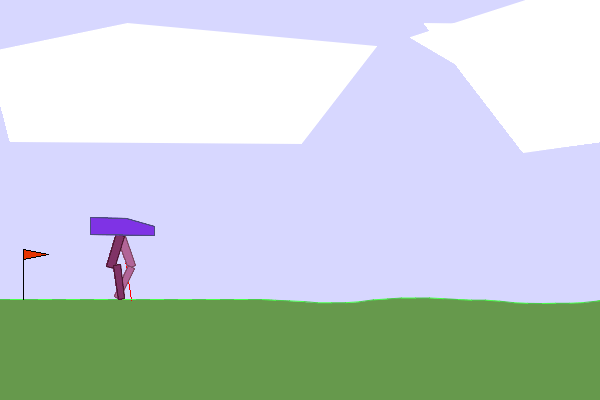

In [80]:
from PIL import Image
from IPython.display import display, Image as IPImage
import io

frames_pil = [Image.fromarray(frame.astype("uint8")) for frame in bestFrames]

buf = io.BytesIO()
frames_pil[0].save(buf, format='GIF', save_all=True, append_images=frames_pil[1:], duration=50, loop=0)
buf.seek(0)

display(IPImage(data=buf.getvalue()))


In [82]:
from PIL import Image, ImageDraw, ImageFont
import io
import os

frames_np = bestFrames

os.makedirs("trainingLogs", exist_ok=True)

frames_pil = []
for frame in frames_np:
    img = Image.fromarray(frame.astype("uint8"))
    draw = ImageDraw.Draw(img)
    
    font_size = img.height // 20
    try:
        font = ImageFont.truetype("arial.ttf", font_size)
    except IOError:
        font = ImageFont.load_default()

    draw.text((10, 10), f"Generation: 10000", fill="white", font=font)
    frames_pil.append(img)

gif_path = f"trainingLogs/generation.gif"
frames_pil[0].save(
    gif_path,
    format="GIF",
    save_all=True,
    append_images=frames_pil[1:],
    duration=50,
    loop=0
)
